In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import random
import os
import matplotlib.pylab as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = path = '/kaggle/working/' 
MODEL_PATH = '/kaggle/input/unet/pytorch/unet_model_70/1/UNET_model_70_t.pt'
TRAIN_IMG_PATH = '/kaggle/input/ct-scans-ds/train_ds/segmented_png'
TRAIN_MASK_PATH = '/kaggle/input/ct-scans-ds/train_ds/mask_png'
TEST_IMG_PATH = '/kaggle/input/ct-scans-ds/test_ds/test/segmented_png'
TEST_MASK_PATH = '/kaggle/input/ct-scans-ds/test_ds/test/mask_png'
# TRAIN_IMG_PATH = path + 'train\\original_png\\'
# TRAIN_MASK_PATH = path + 'train\\mask_png\\'
# TEST_IMG_PATH = path + 'test\\original_png\\'
# TEST_MASK_PATH = path + 'test\\mask_png\\'
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LEARNING_RATE = 1e-4
NUM_EPOCHS = 120
BATCH_SIZE = 16
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False


In [3]:
DEVICE

device(type='cuda')

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64,128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
    
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape)
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
    
        return self.final_conv(x)
        

In [5]:
class CTDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.image_path))

    def __getitem__(self, index):
        img_name = f'{index}.png'
        img_path = os.path.join(self.image_path, img_name)
        mask_path = os.path.join(self.mask_path, img_name)  # Assuming mask files have the same name as image files with "_mask" suffix

        image = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [6]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
#         A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Normalize(
        #     mean=[0.0, 0.0, 0.0],
        #     std=[1.0, 1.0, 1.0],
        #     max_pixel_value=255.0,
        # ),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Normalize(
        #     mean=[0.0, 0.0, 0.0],
        #     std=[1.0, 1.0, 1.0],
        #     max_pixel_value=255.0,
        # ),
        ToTensorV2()
    ]
)                                           

In [7]:
def save_checkpoint(state, path=PATH, filename="model.pt"):
    print("=> Saving checkpoint")
    torch.save(state, path + filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_path, train_mask_path, val_path, val_mask_path, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True):
    train_ds = CTDataset(image_path=train_path, mask_path=train_mask_path, transform=train_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, pin_memory=pin_memory, shuffle=True)
    val_ds = CTDataset(image_path=val_path, mask_path=val_mask_path, transform=val_transform)
    val_loader = DataLoader(val_ds, batch_size=batch_size,pin_memory=pin_memory, shuffle=False)
    return train_loader, val_loader

def check_accuracy(loader, model, history_val, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    recall = 0
    f1 = 0
    precision = 0
    accuracy = 0
    model.eval()

    with torch.no_grad():
        for x,y in tqdm(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum() + 1e-8) / ((preds + y).sum() + 1e-8)
#             y_cpu = [val.cpu() for val in y]
#             pred_cpu = [p.cpu() for p in preds]
#             print(y_cpu)
#             print("_________")
#             print(pred_cpu)
#             recall += (recall_score(y_cpu, pred_cpu) / y_cpu.shape[0])
#             f1 += (f1_score(y_cpu, pred_cpu) / y_cpu.shape[0])
#             precision += (precision_score(y_cpu, pred_cpu) / y_cpu.shape[0])
#             accuracy += (accuracy_score(y_cpu, pred_cpu) / y_cpu.shape[0])
    
#     history_val['recall'].append(recall/len(loader))
#     history_val['f1'].append(f1/len(loader))
#     history_val['precision'].append(precision/len(loader))
#     history_val['accuracy'].append(accuracy/len(loader))

    history_val['val'].append(dice_score/(len(loader)))
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)} ")
    model.train()

def save_predicts_as_imgs(loader, model, folder='saved_images\\', device="cuda"):
    model.eval()
    for idx, (x,y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{PATH + folder}pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{PATH + folder}{idx}.png")

    model.train()

In [8]:
def train_fn(loader, model, optimizer, loss_fn, scaler, history_val):
    loop = tqdm(loader)
    dice_score = 0
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        # with torch.cuda.amp.autocast():
        
        predictions = model(data)
        
        
        preds = torch.sigmoid(predictions)
        preds = (preds > 0.5).float()
        dice_score += (2 * (preds * targets).sum() + 1e-8) / ((preds + targets).sum() + 1e-8)
        
        loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        # loss = criterion(y_pred, mask)
        loss.backward()
        optimizer.step()
        
        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    
    history_val['train'].append(dice_score/(len(loader)))
    

In [9]:
model = UNET(in_channels=1, out_channels=1).to(device=DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_loader, val_loader = get_loaders(
    TRAIN_IMG_PATH,
    TRAIN_MASK_PATH,
    TEST_IMG_PATH,
    TEST_MASK_PATH,
    BATCH_SIZE,
    train_transform,
    val_transform
)

In [10]:
if LOAD_MODEL:
    load_checkpoint(torch.load(MODEL_PATH), model)

history_val = {'train':[], 'val':[], 'recall':[], 'precision':[], 'f1':[], 'accuracy':[]}

check_accuracy(val_loader, model, history_val, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler, history_val)
    
    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, history_val, device=DEVICE)

    #print some examples to a folder
    save_predicts_as_imgs(val_loader, model, folder="saved_images\\", device=DEVICE)

100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Got 400841/17301504 with acc 2.32
Dice score: 0.0017110119806602597 


100%|██████████| 45/45 [00:29<00:00,  1.54it/s, loss=0.464]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17005644/17301504 with acc 98.29
Dice score: 0.014330836944282055 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.365]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


Got 16873859/17301504 with acc 97.53
Dice score: 0.009947050362825394 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.345]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.321]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17270148/17301504 with acc 99.82
Dice score: 2.0166123979037387e-11 


100%|██████████| 45/45 [00:21<00:00,  2.13it/s, loss=0.291]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.44it/s]


Got 17285781/17301504 with acc 99.91
Dice score: 2.8633736007255273e-11 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.324]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.27] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.241]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.50it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.23] 


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


Got 17286114/17301504 with acc 99.91
Dice score: 2.9167356030423974e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.222]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.50it/s]


Got 17286132/17301504 with acc 99.91
Dice score: 2.9215112967717616e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.204]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17273264/17301504 with acc 99.84
Dice score: 2.0662848168595538e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.191]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.51it/s]


Got 17245773/17301504 with acc 99.68
Dice score: 1.8599051118672882e-11 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.178]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.51it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.163]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.51it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.159]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17286104/17301504 with acc 99.91
Dice score: 2.9107560112207054e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.154]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.47it/s]


Got 17285820/17301504 with acc 99.91
Dice score: 2.7957868659056473e-11 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.135]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.139]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.12] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.118]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.113]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.106] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.0961]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.51it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0895]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17286146/17301504 with acc 99.91
Dice score: 2.921589706272876e-11 


100%|██████████| 45/45 [00:21<00:00,  2.13it/s, loss=0.0877]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286151/17301504 with acc 99.91
Dice score: 0.0005119541310705245 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0829]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17282984/17301504 with acc 99.89
Dice score: 0.031593188643455505 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.0763]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17284612/17301504 with acc 99.90
Dice score: 0.006323184352368116 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0708]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17285924/17301504 with acc 99.91
Dice score: 0.003332411404699087 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0684]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.58it/s]


Got 17285494/17301504 with acc 99.91
Dice score: 0.03641720116138458 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0629]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17285511/17301504 with acc 99.91
Dice score: 0.013780364766716957 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.0615]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.50it/s]


Got 17283186/17301504 with acc 99.89
Dice score: 0.06642753630876541 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0544]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17281727/17301504 with acc 99.89
Dice score: 0.07047173380851746 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.0512]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17285590/17301504 with acc 99.91
Dice score: 0.03543879836797714 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.055] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17285231/17301504 with acc 99.91
Dice score: 0.026197701692581177 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.0505]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17285462/17301504 with acc 99.91
Dice score: 0.0736955776810646 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0483]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17266753/17301504 with acc 99.80
Dice score: 0.12366113811731339 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0454]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17275548/17301504 with acc 99.85
Dice score: 0.13451527059078217 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0421]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17281150/17301504 with acc 99.88
Dice score: 0.06364081054925919 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.0406]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.50it/s]


Got 17283284/17301504 with acc 99.89
Dice score: 0.16261425614356995 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0386]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17284115/17301504 with acc 99.90
Dice score: 0.08820557594299316 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.035] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17281757/17301504 with acc 99.89
Dice score: 0.23215351998806 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0338]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17282607/17301504 with acc 99.89
Dice score: 0.15429934859275818 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.0324]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17281628/17301504 with acc 99.89
Dice score: 0.25875023007392883 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0316]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286138/17301504 with acc 99.91
Dice score: 0.1896955966949463 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.0287]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17284821/17301504 with acc 99.90
Dice score: 0.23386530578136444 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0277]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17283300/17301504 with acc 99.89
Dice score: 0.22311431169509888 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0262]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17283466/17301504 with acc 99.90
Dice score: 0.2369832992553711 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0257]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17283945/17301504 with acc 99.90
Dice score: 0.2809005379676819 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0242]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17283857/17301504 with acc 99.90
Dice score: 0.2748860716819763 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0246]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286131/17301504 with acc 99.91
Dice score: 0.23910102248191833 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0223]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17285410/17301504 with acc 99.91
Dice score: 0.23418082296848297 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0224]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.58it/s]


Got 17284199/17301504 with acc 99.90
Dice score: 0.27705711126327515 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0203]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17285589/17301504 with acc 99.91
Dice score: 0.23447445034980774 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0206]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17287840/17301504 with acc 99.92
Dice score: 0.2350444793701172 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0188]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17283742/17301504 with acc 99.90
Dice score: 0.24866990745067596 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.019] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17286420/17301504 with acc 99.91
Dice score: 0.2551644742488861 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.019] 


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


Got 17289057/17301504 with acc 99.93
Dice score: 0.3133414387702942 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.0171]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17284188/17301504 with acc 99.90
Dice score: 0.2606203854084015 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.018] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17284636/17301504 with acc 99.90
Dice score: 0.2504744231700897 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0191]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17285492/17301504 with acc 99.91
Dice score: 0.2665426731109619 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0172]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17287459/17301504 with acc 99.92
Dice score: 0.2683648467063904 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0152]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17285240/17301504 with acc 99.91
Dice score: 0.283159464597702 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0154]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17287741/17301504 with acc 99.92
Dice score: 0.23910626769065857 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0144]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17288069/17301504 with acc 99.92
Dice score: 0.24205799400806427 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0141]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17288177/17301504 with acc 99.92
Dice score: 0.28029659390449524 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0135]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17285362/17301504 with acc 99.91
Dice score: 0.24510730803012848 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0121]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286616/17301504 with acc 99.91
Dice score: 0.2624942660331726 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.0141]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.58it/s]


Got 17287540/17301504 with acc 99.92
Dice score: 0.22279110550880432 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0125]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17285744/17301504 with acc 99.91
Dice score: 0.2716641128063202 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0167]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17277334/17301504 with acc 99.86
Dice score: 0.30693379044532776 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0116]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17285376/17301504 with acc 99.91
Dice score: 0.2906967103481293 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.01]  


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17287718/17301504 with acc 99.92
Dice score: 0.2595665156841278 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00996]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17288488/17301504 with acc 99.92
Dice score: 0.2704046368598938 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00955]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286574/17301504 with acc 99.91
Dice score: 0.2658631503582001 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.012]  


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17287314/17301504 with acc 99.92
Dice score: 0.29798203706741333 


100%|██████████| 45/45 [00:21<00:00,  2.13it/s, loss=0.00904]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17287012/17301504 with acc 99.92
Dice score: 0.3335902988910675 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.00912]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17288454/17301504 with acc 99.92
Dice score: 0.30195021629333496 


100%|██████████| 45/45 [00:21<00:00,  2.13it/s, loss=0.0122] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286955/17301504 with acc 99.92
Dice score: 0.25286269187927246 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00969]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17288609/17301504 with acc 99.93
Dice score: 0.2727796733379364 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00768]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286473/17301504 with acc 99.91
Dice score: 0.18863967061042786 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0076] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17288227/17301504 with acc 99.92
Dice score: 0.27929285168647766 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00754]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286649/17301504 with acc 99.91
Dice score: 0.29373812675476074 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00781]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17285834/17301504 with acc 99.91
Dice score: 0.2929702401161194 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00719]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17283526/17301504 with acc 99.90
Dice score: 0.28372329473495483 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00709]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17286237/17301504 with acc 99.91
Dice score: 0.1393953412771225 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00682]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17287188/17301504 with acc 99.92
Dice score: 0.2873886823654175 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00616]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17285657/17301504 with acc 99.91
Dice score: 0.23952259123325348 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00853]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286712/17301504 with acc 99.91
Dice score: 0.13691894710063934 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00599]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17288079/17301504 with acc 99.92
Dice score: 0.27113768458366394 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00648]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17288335/17301504 with acc 99.92
Dice score: 0.30446678400039673 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00639]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17287700/17301504 with acc 99.92
Dice score: 0.2863001525402069 


100%|██████████| 45/45 [00:21<00:00,  2.13it/s, loss=0.00584]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.47it/s]


Got 17287129/17301504 with acc 99.92
Dice score: 0.25129395723342896 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.0054] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17286379/17301504 with acc 99.91
Dice score: 0.221293106675148 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.00794]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17285923/17301504 with acc 99.91
Dice score: 0.1853695660829544 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00647]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17287448/17301504 with acc 99.92
Dice score: 0.23940855264663696 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.00563]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17287212/17301504 with acc 99.92
Dice score: 0.3211045563220978 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.005]  


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17288366/17301504 with acc 99.92
Dice score: 0.3416583240032196 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.00511]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17288378/17301504 with acc 99.92
Dice score: 0.2627127468585968 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00503]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.57it/s]


Got 17285521/17301504 with acc 99.91
Dice score: 0.2715814411640167 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00508]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17286790/17301504 with acc 99.91
Dice score: 0.17981116473674774 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00569]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17287900/17301504 with acc 99.92
Dice score: 0.34225592017173767 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00679]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.49it/s]


Got 17288326/17301504 with acc 99.92
Dice score: 0.30036094784736633 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0108] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17286197/17301504 with acc 99.91
Dice score: 0.40265247225761414 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00435]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17287661/17301504 with acc 99.92
Dice score: 0.21190547943115234 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00513]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17287540/17301504 with acc 99.92
Dice score: 0.3403480052947998 


100%|██████████| 45/45 [00:21<00:00,  2.14it/s, loss=0.00389]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17288835/17301504 with acc 99.93
Dice score: 0.33756011724472046 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00404]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17287754/17301504 with acc 99.92
Dice score: 0.32199206948280334 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00366]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.53it/s]


Got 17288430/17301504 with acc 99.92
Dice score: 0.29778242111206055 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00439]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17285766/17301504 with acc 99.91
Dice score: 0.16156505048274994 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00351]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17288136/17301504 with acc 99.92
Dice score: 0.3447056710720062 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00347]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17288170/17301504 with acc 99.92
Dice score: 0.3222165107727051 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00481]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17285812/17301504 with acc 99.91
Dice score: 0.2410498857498169 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00372]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17289300/17301504 with acc 99.93
Dice score: 0.3478071391582489 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0032] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


Got 17286610/17301504 with acc 99.91
Dice score: 0.23639236390590668 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00333]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17288309/17301504 with acc 99.92
Dice score: 0.303011029958725 


100%|██████████| 45/45 [00:20<00:00,  2.14it/s, loss=0.00327]


=> Saving checkpoint


100%|██████████| 17/17 [00:02<00:00,  8.44it/s]


Got 17287471/17301504 with acc 99.92
Dice score: 0.2123134881258011 


100%|██████████| 45/45 [00:21<00:00,  2.13it/s, loss=0.00381]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17287764/17301504 with acc 99.92
Dice score: 0.30438587069511414 


100%|██████████| 45/45 [00:20<00:00,  2.16it/s, loss=0.00281]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.56it/s]


Got 17288159/17301504 with acc 99.92
Dice score: 0.31210753321647644 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.0029] 


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.55it/s]


Got 17286287/17301504 with acc 99.91
Dice score: 0.32490572333335876 


100%|██████████| 45/45 [00:20<00:00,  2.15it/s, loss=0.00538]


=> Saving checkpoint


100%|██████████| 17/17 [00:01<00:00,  8.54it/s]


Got 17288891/17301504 with acc 99.93
Dice score: 0.32877102494239807 


In [11]:
history_val

{'train': [tensor(0.0161, device='cuda:0'),
  tensor(0.0034, device='cuda:0'),
  tensor(0.0037, device='cuda:0'),
  tensor(0.0024, device='cuda:0'),
  tensor(0.0004, device='cuda:0'),
  tensor(5.6716e-12, device='cuda:0'),
  tensor(6.0368e-12, device='cuda:0'),
  tensor(0.0007, device='cuda:0'),
  tensor(0.0004, device='cuda:0'),
  tensor(0.0005, device='cuda:0'),
  tensor(7.0621e-12, device='cuda:0'),
  tensor(6.7250e-12, device='cuda:0'),
  tensor(0.0005, device='cuda:0'),
  tensor(6.8151e-12, device='cuda:0'),
  tensor(6.8619e-12, device='cuda:0'),
  tensor(6.8948e-12, device='cuda:0'),
  tensor(6.7135e-12, device='cuda:0'),
  tensor(6.6018e-12, device='cuda:0'),
  tensor(7.1669e-12, device='cuda:0'),
  tensor(6.9824e-12, device='cuda:0'),
  tensor(6.6648e-12, device='cuda:0'),
  tensor(7.3150e-12, device='cuda:0'),
  tensor(7.3254e-12, device='cuda:0'),
  tensor(7.4153e-12, device='cuda:0'),
  tensor(0.0290, device='cuda:0'),
  tensor(0.1975, device='cuda:0'),
  tensor(0.3123, devi

In [12]:
train_dice_val = [h.cpu() for h in history_val['train']]
val_dice_val = [h.cpu() for h in history_val['val']]
train_dice_val, val_dice_val

([tensor(0.0161),
  tensor(0.0034),
  tensor(0.0037),
  tensor(0.0024),
  tensor(0.0004),
  tensor(5.6716e-12),
  tensor(6.0368e-12),
  tensor(0.0007),
  tensor(0.0004),
  tensor(0.0005),
  tensor(7.0621e-12),
  tensor(6.7250e-12),
  tensor(0.0005),
  tensor(6.8151e-12),
  tensor(6.8619e-12),
  tensor(6.8948e-12),
  tensor(6.7135e-12),
  tensor(6.6018e-12),
  tensor(7.1669e-12),
  tensor(6.9824e-12),
  tensor(6.6648e-12),
  tensor(7.3150e-12),
  tensor(7.3254e-12),
  tensor(7.4153e-12),
  tensor(0.0290),
  tensor(0.1975),
  tensor(0.3123),
  tensor(0.4531),
  tensor(0.3664),
  tensor(0.5226),
  tensor(0.5818),
  tensor(0.5998),
  tensor(0.6247),
  tensor(0.6099),
  tensor(0.6053),
  tensor(0.6366),
  tensor(0.6614),
  tensor(0.6828),
  tensor(0.6798),
  tensor(0.6950),
  tensor(0.7174),
  tensor(0.7248),
  tensor(0.7184),
  tensor(0.7249),
  tensor(0.7296),
  tensor(0.7466),
  tensor(0.7553),
  tensor(0.7519),
  tensor(0.7666),
  tensor(0.7892),
  tensor(0.7657),
  tensor(0.7620),
  te

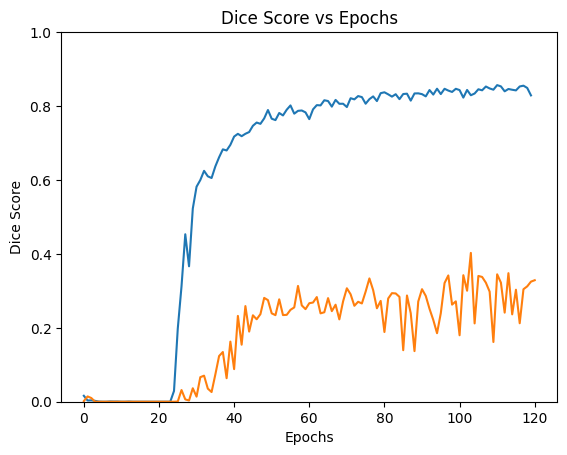

In [13]:
plt.plot(train_dice_val)
plt.plot(val_dice_val)
plt.title('Dice Score vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.ylim(0, 1)
plt.show()

In [ ]:
mask_one = Image.open(train_image_path + "0.png")
mask_one

In [ ]:
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 
  
# transform = transforms.PILToTensor() 
# Convert the PIL image to Torch tensor 
mask_one_tensor = transform(mask_one)
mask_one_tensor[mask_one_tensor==255] = 1
# mask_one_tensor.float().unsqueeze(1)
mask_one_tensor.min(), mask_one_tensor.max(), mask_one_tensor.shape

In [ ]:
x = torch.randn((3,1, 160, 160))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape

In [ ]:
a=[1,1,1]
b=np.array([0,1,0])
(b > 0).sum()

/tmp/ipykernel_34/4218296395.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3614.)
  axarr[0].imshow(x[0].T)


<Figure size 640x480 with 0 Axes>

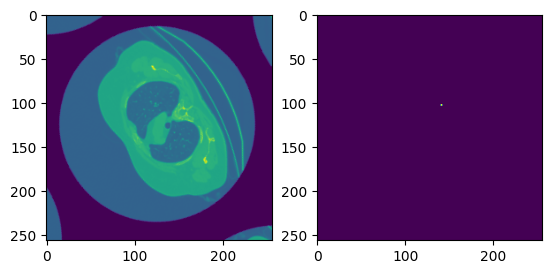

In [25]:
table = {'0': 0, '1': 0}
for x, y in train_loader:
    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x[0].T)
    axarr[1].imshow(y[0].T)
    break

In [32]:
for epoch in range(NUM_EPOCHS):
    table = {'0': 0, '1': 0}
    for x, y in train_loader:
        for j in range(y.shape[0]):
            if y[j].max() == 1:
                table['1'] += 1
            else:
                table['0'] += 1
    print(f"{epoch}: 0 is {table['0']/708:.2f}, 1 is {table['1']/708:.2f}")

0: 0 is 0.45, 1 is 0.55
1: 0 is 0.43, 1 is 0.57
2: 0 is 0.46, 1 is 0.54
3: 0 is 0.43, 1 is 0.57
4: 0 is 0.42, 1 is 0.58
5: 0 is 0.42, 1 is 0.58
6: 0 is 0.44, 1 is 0.56
7: 0 is 0.38, 1 is 0.62
8: 0 is 0.42, 1 is 0.58
9: 0 is 0.42, 1 is 0.58
10: 0 is 0.46, 1 is 0.54
11: 0 is 0.46, 1 is 0.54
12: 0 is 0.41, 1 is 0.59
13: 0 is 0.39, 1 is 0.61
14: 0 is 0.39, 1 is 0.61
15: 0 is 0.41, 1 is 0.59
16: 0 is 0.44, 1 is 0.56
17: 0 is 0.40, 1 is 0.60
18: 0 is 0.43, 1 is 0.57
19: 0 is 0.42, 1 is 0.58
20: 0 is 0.42, 1 is 0.58
21: 0 is 0.43, 1 is 0.57
22: 0 is 0.41, 1 is 0.59
23: 0 is 0.43, 1 is 0.57
24: 0 is 0.44, 1 is 0.56
25: 0 is 0.43, 1 is 0.57


KeyboardInterrupt: 